In [44]:
import os
import time
from keras.preprocessing import image
from keras.models import save_model, load_model
from keras import utils
from sklearn import metrics
import numpy as np
import math
import cv2
import random


In [2]:
## EXTRACTING IMAGE FEATURES

## Create a function to extract features from each image in a directory

def load_directory(directory_name):
    image_feature_list = []
    filenames = [item for item in os.listdir(directory_name) if item.lower().endswith(".jpg")]
    random.shuffle(filenames)
    for filename in filenames:
        file_path = directory_name + "/" + filename
        
        image_object = image.load_img(file_path, grayscale=False, color_mode="rgb", target_size=(224,224), interpolation="nearest")

        image_array = image.img_to_array(image_object, data_format=None, dtype=None)

        image_feature_list.append(image_array)

    time.sleep(0.7)
    return image_feature_list

In [3]:
## TRAINING/LOADING CLASSIFIER MODEL

## Ask whether the user wants to train a new model
user_input = input("Do you want to train a new CNN model? ")


if user_input in ["y", "yes"]:
    ## Import modules here to save time when loading a saved model
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.layers import Dropout, Flatten, Dense

    ## Loading image data
    bear_features = load_directory("Bear_Train")
    not_bear_features = load_directory("Not_Bear_Train")

    ## Creating combined feature lists
    X = np.array(bear_features + not_bear_features)
    y = np.array([0]*len(bear_features) + [1]*len(not_bear_features))
    y = utils.to_categorical(y, 3)

    # Creating a convolutional neural network
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3,activation='softmax')) ## Including the number of classes + 1

    ## Compiling the model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


    ## Training the model 
    model.fit(X, y, epochs = 15, verbose = 10)

    ## Save model to disk
    file_path = 'bear_model.h5'
    save_model(model, file_path, save_format='h5')

else:
    ## Otherwise, load the previous trained model
    model = load_model('bear_model.h5', custom_objects=None, compile=True)


Do you want to train a new CNN model? y
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


In [4]:
## Print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0

In [5]:
## DEFINING A FUNCTION TO CLASSIFY EACH IMAGE IN A DIRECTORY

def classify_directory(image_directory):
    photos_to_classify = []

    image_filenames = [item for item in os.listdir(image_directory) if item.lower().endswith(".jpg")]

    for filename in image_filenames:
        
        file_path = image_directory + "/" + filename

        image_object = image.load_img(file_path, grayscale=False, color_mode="rgb", target_size=(224,224), interpolation="nearest")

        image_array = image.img_to_array(image_object, data_format=None, dtype=None)
        photos_to_classify.append(image_array)


    photos_to_classify = np.array(photos_to_classify)
    
    predictions = model.predict(photos_to_classify)
    
    file_predictions = list(zip(image_filenames, predictions))

    return file_predictions


In [55]:
## CLASSIFYING THE TEST DATA

## Predict the test image sets
bear_test_predictions = classify_directory("Bear_Test")
not_bear_test_predictions = classify_directory("Not_Bear_Test")

## Print classifier output for a random image
print("Example classifier output:")
print(random.choice(bear_test_predictions))

Example classifier output:
('48177762150.jpg', array([5.8558178e-01, 4.1409665e-01, 3.2154837e-04], dtype=float32))


In [ ]:
## Create a combined list of true labels for the test set

y_true = [0]*len(bear_test_predictions) + [1]*len(not_bear_test_predictions)


## Create a combined list of predictions

y_predictions = []

for pair in bear_test_predictions:
    prediction_array = pair[1]
    if prediction_array[0] > 0.5:
        y_predictions.append(0)
    else:
        y_predictions.append(1)
        
        
for pair in not_bear_test_predictions:
    prediction_array = pair[1]
    if prediction_array[1] > 0.5:
        y_predictions.append(0)
    else:
        y_predictions.append(1)


In [59]:
## EVALUATING CNN MODEL PERFORMANCE

## Print accuracy score
accuracy = metrics.accuracy_score(y_true, y_predictions)
accuracy = round(accuracy, 2)
print(f"Accuracy score: {accuracy}")
print()

## Print precision score
precision = metrics.precision_score(y_true, y_predictions, average='binary')
precision = round(precision, 2)
print(f"Precision score: {precision}")
print()

## Print recall score
recall = recall_score(y_true, y_predictions, average='binary')
recall = round(recall, 2)
print(f"Recall score: {recall}")
print()

## Print confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, y_predictions)
confusion_matrix_output = f'''Confusion Matrix:
  true positive: {confusion_matrix[0][0]}   false positive: {confusion_matrix[0][1]}
  false negative: {confusion_matrix[1][0]}  true negative": {confusion_matrix[1][1]}'''
print(confusion_matrix_output)
print()


Accuracy score: 0.68

Precision score: 0.79

Recall score: 0.33

Confusion Matrix:
  true positive: 75   false positive: 5
  false negative: 39  true negative": 19



In [50]:
## APPLYING THE MODEL TO UNKNOWN DATA

## Convert a video file to a series of JPEG images

os.chdir("Alaska_Trail_Cam")
videoFile = "Alaska Trail Cam Video. August 16, 2020.mp4"
counter = 0
# Capturing video data
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
            break
    if (frameId % math.floor(frameRate) == 0):
        filename = f"frame_{counter}.jpg"
        counter+=1
        cv2.imwrite(filename, frame)

cap.release()
os.chdir("../")

In [10]:
## Classify each image in the unknown dataset

directory_to_classify = "Alaska_Trail_Cam"
bear_predictions = classify_directory(directory_to_classify)

Prediction_values:
[0.30844483 0.69155514]

The classifier thinks this is *not* a bear.


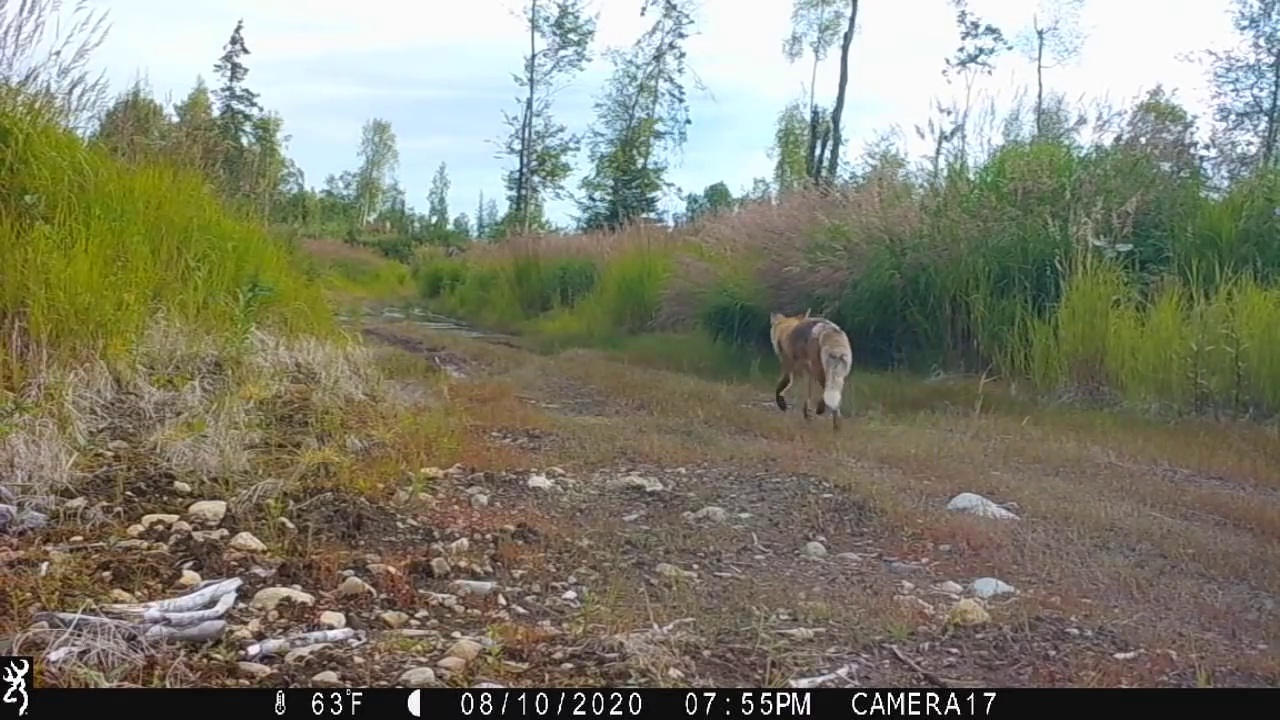

In [15]:
## VIEWING CLASSIFICATION EXAMPLES AT RANDOM

from IPython.display import Image

## Output prediction for random image
random_prediction = random.choice(bear_predictions)
prediction_values = random_prediction[1][:2]
print("Prediction_values:")
print(prediction_values)
print()
if prediction_values[0]>prediction_values[1]:
    print("The classifier thinks this is a bear.")
else:
    print("The classifier thinks this is *not* a bear.")

## View image
image_path = directory_to_classify + "/" + random_prediction[0]
Image(filename=image_path) 

Prediction_values:
[0.507462   0.48863706]

The classifier thinks this is a bear.


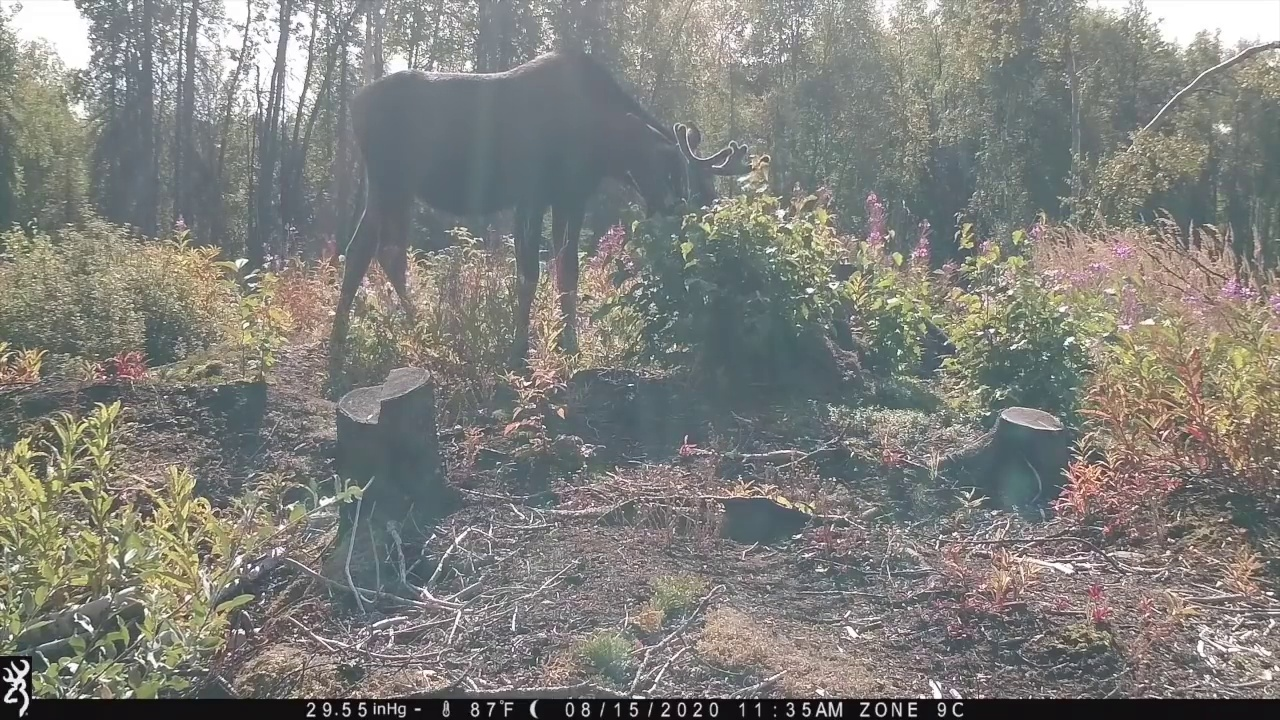

In [18]:
## Output prediction for random image
random_prediction = random.choice(bear_predictions)
prediction_values = random_prediction[1][:2]
print("Prediction_values:")
print(prediction_values)
print()
if prediction_values[0]>prediction_values[1]:
    print("The classifier thinks this is a bear.")
else:
    print("The classifier thinks this is *not* a bear.")

## View image
image_path = directory_to_classify + "/" + random_prediction[0]
Image(filename=image_path) 

Prediction_values:
[0.53286284 0.462298  ]

The classifier thinks this is a bear.


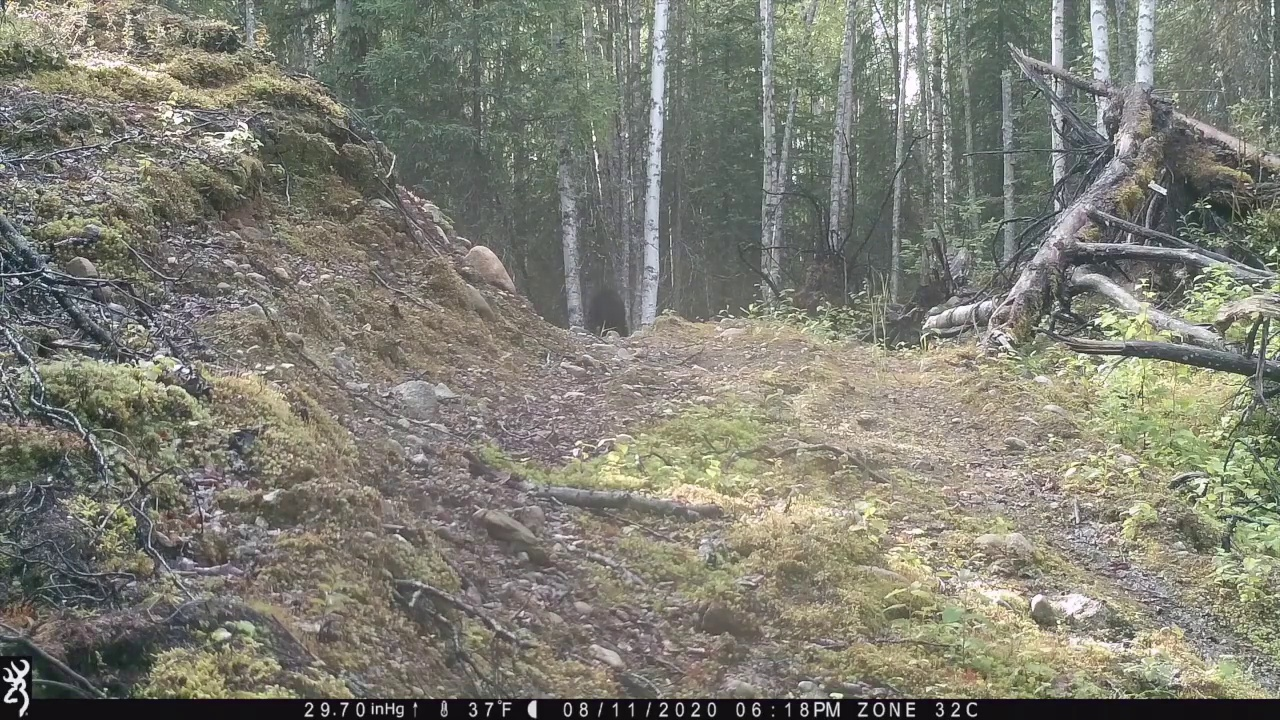

In [43]:
## Output prediction for random image
random_prediction = random.choice(bear_predictions)
prediction_values = random_prediction[1][:2]
print("Prediction_values:")
print(prediction_values)
print()
if prediction_values[0]>prediction_values[1]:
    print("The classifier thinks this is a bear.")
else:
    print("The classifier thinks this is *not* a bear.")

image_path = directory_to_classify + "/" + random_prediction[0]
Image(filename=image_path) 